In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import one_hot
from keras.utils import np_utils
from sklearn.preprocessing import label_binarize

Using TensorFlow backend.


In [0]:
train = pd.read_csv('/content/DataSet/train.csv')
test = pd.read_csv('/content/DataSet/test.csv')

In [3]:
x_train = train['sentence'].as_matrix()
y_train = train['relation'].as_matrix()
x_test = test['sentence'].as_matrix()
y_test = test['relation'].as_matrix()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [0]:
x_train2c=[]
x_train2t=[]
#y_train2=[]

for i in range(13340):
  if y_train[i] == 'causes':
    x_train2c.append(x_train[i])
    #y_train2.append(0)
  elif y_train[i] == 'treats':
    x_train2t.append(x_train[i])
    #y_train2.append(1)  
    
x_test2c=[]
x_test2t=[]

for i in range(4566):
  if y_test[i] == 'causes':
    x_test2c.append(x_test[i])
    #y_test2.append(y_test[i])
  elif y_test[i] == 'treats':
    x_test2t.append(x_test[i])
    #y_test2.append(y_test[i]) 

In [0]:
causesTrain=pd.Series(x_train2c).unique()
treatsTrain=pd.Series(x_train2t).unique()
causesTest=pd.Series(x_test2c).unique()
treatsTest=pd.Series(x_test2t).unique()


In [0]:
X_train=[]
X_test=[]
y_train=[]
y_test=[]
for i in causesTrain:
  X_train.append(i)
  y_train.append(0)
for i in treatsTrain:
  X_train.append(i)
  y_train.append(1)
for i in causesTest:
  X_test.append(i)
  y_test.append(0)
for i in treatsTest:
  X_test.append(i)
  y_test.append(1) 

In [0]:
df=pd.DataFrame()
df['Frase']=X_train
df['Label']=y_train

In [0]:
dftest=pd.DataFrame()
dftest['Frase']=X_test
dftest['Label']=y_test

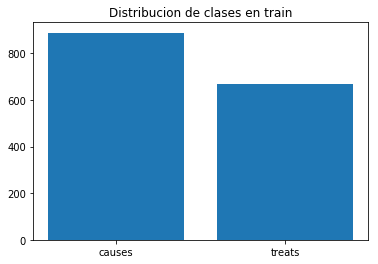

In [12]:
plt.bar(['causes','treats'],df['Label'].value_counts())
plt.title('Distribucion de clases en train');

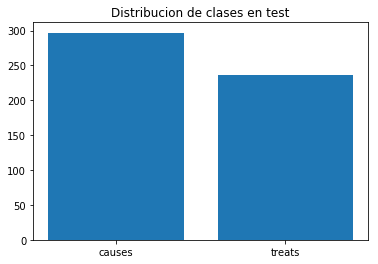

In [13]:
plt.bar(['causes','treats'],dftest['Label'].value_counts())
plt.title('Distribucion de clases en test');

* Existe desbalance de clase, lo tendremos en cuenta en los parametros del modelo.

* El set de datos estaba particionado completamente, aplicamos un muestreo para 'desordenar' el dataframe.

In [15]:
dftest=dftest.sample(frac=1).reset_index(drop=True)
df=df.sample(frac=1).reset_index(drop=True)
df.head(10)

,Frase,Label
0,Vaccination against NICOTINE represents a prom...,1
1,"Schmitt C, Sobel JD, Meriwether CBACTERIAL VAG...",1
2,"e.g., DIMENHYDRINATE MECLIZINE ANTI EMETICS th...",1
3,"Indeed, administration of galanin receptor ago...",0
4,"Evidence: In a randomized controlled trial, m...",1
5,BLASTOID MANTLE CELL LYMPHOMA (BV MCL) is a ra...,1
6,In chronic active hepatitis of viral (132 case...,0
7,LACTULOSE reduced symptoms of HEPATIC ENCEPHAL...,0
8,Antigens are commonly categorized by type and ...,0
9,Illingworth DR. Mevinolin plus COLESTIPOL in t...,1


### Preprocesamiento de los datos

* Eliminacion de Stopwords y palabras no deseadas
* Tokenizacion
* Padding

In [21]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
aW=[]
# Removing Stop Words
import re 
processed_article = df['Frase'].values

for j in range(df['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aW.append(all_words[0])

In [0]:
aWt=[]
# Removing Stop Words
import re 
processed_article = dftest['Frase'].values

for j in range(dftest['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aWt.append(all_words[0])

* 2000 palabras para el tokenizer

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X = tokenizer.texts_to_sequences(aW)
Xt = tokenizer.texts_to_sequences(aWt)

* Padding :

In [30]:
from keras.preprocessing.sequence import pad_sequences
Xpad=pad_sequences(X,padding='post',maxlen=25)
voc=Xpad[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad[0].size))

El tamaño maximo de la secuencia es 25


In [31]:
Xpadt=pad_sequences(Xt,padding='post',maxlen=25)
voct=Xpadt[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpadt[0].size))

El tamaño maximo de la secuencia es 25


In [32]:
Xpad[1005]

array([ 515,   31,   17,   62,  399, 1790, 1104,  333,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

### Entrenamiento:
Utilizaremos una arquitectura compuesta por:
* Embedding
* LSTM
* Dense

In [0]:
from keras.layers import Dense,LSTM,Dropout,GRU,SimpleRNN,Embedding,Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [34]:
model =Sequential()
model.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model.compile('adam','mse')
out=model.predict(Xpad) # x train
out.shape

(1558, 25, 128)

From the Keras documentation:

* dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.

* recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.



In [35]:
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dense(units=1,activation='relu'))
model1.compile('adam','binary_crossentropy',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.9050 - acc: 0.6104 - val_loss: 0.5473 - val_acc: 0.7261
Epoch 2/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4630 - acc: 0.7863 - val_loss: 0.7125 - val_acc: 0.7824
Epoch 3/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.3911 - acc: 0.8350 - val_loss: 1.0720 - val_acc: 0.7373
Epoch 4/25
1558/1558 [==============================] - 5s 4ms/step - loss: 0.4055 - acc: 0.7895 - val_loss: 1.2466 - val_acc: 0.6548
Epoch 5/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.5105 - acc: 0.7811 - val_loss: 1.0536 - val_acc: 0.7749
Epoch 6/25
1558/1558 [==============================] - 5s 4ms/step - loss: 0.3960 - acc: 0.8062 - val_loss: 1.2453 - va

Text(0,0.5,'Loss')

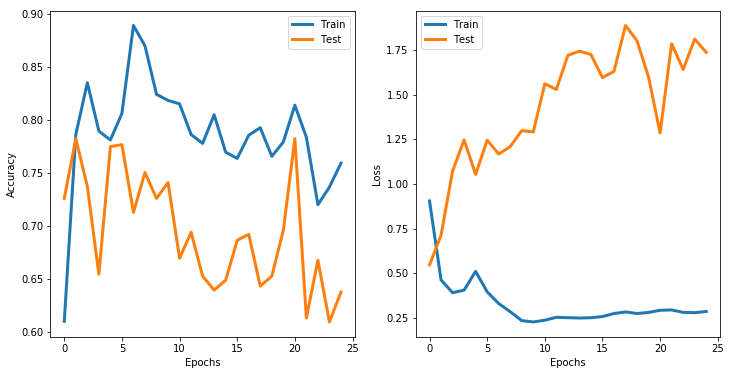

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

* Añadimos una capa Dropout y experimentamos con una funcion de costo mse a pesar que lo optimo  teoricamente es binary_crossentropy

In [38]:
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=150, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='relu'))
model1.compile('adam','mse',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values))

Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.2298 - acc: 0.6746 - val_loss: 0.1491 - val_acc: 0.7899
Epoch 2/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0943 - acc: 0.8819 - val_loss: 0.1427 - val_acc: 0.8030
Epoch 3/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0627 - acc: 0.9288 - val_loss: 0.1415 - val_acc: 0.8161
Epoch 4/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0490 - acc: 0.9384 - val_loss: 0.1470 - val_acc: 0.8086
Epoch 5/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0407 - acc: 0.9467 - val_loss: 0.1534 - val_acc: 0.8049
Epoch 6/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0371 - acc: 0.9538 - val_loss: 0.1601 - val_acc: 0.7955
Epoch 7/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0357 - acc: 0.9519 - val_loss: 0.1585 - val_acc: 0.8011
Epoch 8/25
1558

Text(0,0.5,'Loss')

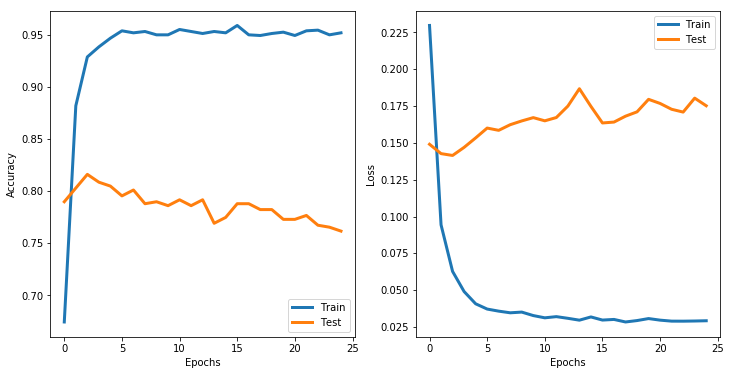

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [40]:
from sklearn.metrics import classification_report
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.81      0.74      0.78       297
 Tratamiento       0.71      0.78      0.74       236

   micro avg       0.76      0.76      0.76       533
   macro avg       0.76      0.76      0.76       533
weighted avg       0.77      0.76      0.76       533



*  Presenta una buena clasificacion  para ambas clases, se procedera en la busqueda de hiperparametros que estabilicen el aprendizaje del modelo.

* Se ajustael optimizador Adam y se introduce el parametro de *class_weights*  para lidiar con el desbalanceo de clases favoreciendo la clase 

In [41]:
opt = Adam(lr=0.0001, decay=1e-5)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='relu'))
model1.compile(optimizer=opt,loss='mse',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1})

Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 7s 5ms/step - loss: 0.3858 - acc: 0.5700 - val_loss: 0.3275 - val_acc: 0.5572
Epoch 2/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.2381 - acc: 0.5969 - val_loss: 0.2422 - val_acc: 0.6154
Epoch 3/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1805 - acc: 0.7003 - val_loss: 0.2013 - val_acc: 0.7111
Epoch 4/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1322 - acc: 0.7978 - val_loss: 0.1712 - val_acc: 0.7523
Epoch 5/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.1059 - acc: 0.8440 - val_loss: 0.1579 - val_acc: 0.7805
Epoch 6/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0874 - acc: 0.8813 - val_loss: 0.1504 - val_acc: 0.7917
Epoch 7/25
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0768 - acc: 0.8902 - val_loss: 0.1432 - val_acc: 0.7974
Epoch 8/25
1558

Text(0,0.5,'Loss')

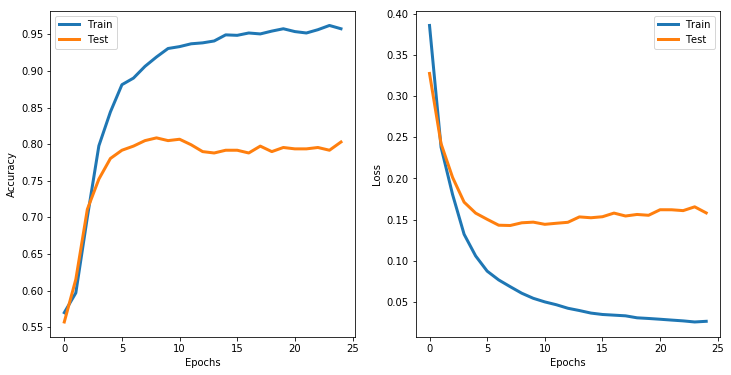

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [43]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.82      0.84      0.83       297
 Tratamiento       0.79      0.76      0.78       236

   micro avg       0.80      0.80      0.80       533
   macro avg       0.80      0.80      0.80       533
weighted avg       0.80      0.80      0.80       533



* Mejora el desbalance en la precision obtenida por clase y entrega un resultado considerablemente bueno.

* Usaremos ahora activacion: sigmoid y loss : binary_crossentropy

In [44]:
opt = Adam(lr=0.0001, decay=1e-5)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid'))
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=20, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1})

Train on 1558 samples, validate on 533 samples
Epoch 1/20
1558/1558 [==============================] - 8s 5ms/step - loss: 0.5930 - acc: 0.6142 - val_loss: 0.6891 - val_acc: 0.7111
Epoch 2/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.5860 - acc: 0.7721 - val_loss: 0.6721 - val_acc: 0.7917
Epoch 3/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.5050 - acc: 0.8184 - val_loss: 0.5632 - val_acc: 0.8049
Epoch 4/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.4111 - acc: 0.8383 - val_loss: 0.5291 - val_acc: 0.8105
Epoch 5/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.3529 - acc: 0.8768 - val_loss: 0.5076 - val_acc: 0.8161
Epoch 6/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.3077 - acc: 0.8909 - val_loss: 0.4950 - val_acc: 0.8293
Epoch 7/20
1558/1558 [==============================] - 6s 4ms/step - loss: 0.2696 - acc: 0.9037 - val_loss: 0.5056 - val_acc: 0.8180
Epoch 8/20
1558

Text(0,0.5,'Loss')

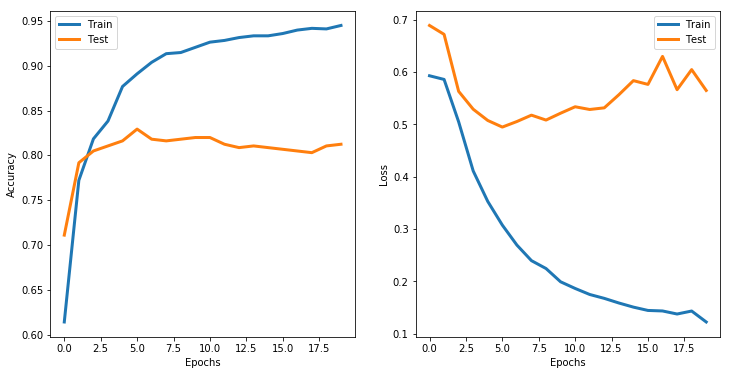

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [46]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.85      0.80      0.83       297
 Tratamiento       0.77      0.82      0.80       236

   micro avg       0.81      0.81      0.81       533
   macro avg       0.81      0.81      0.81       533
weighted avg       0.81      0.81      0.81       533



* Es un resultado similar el obtenidio con MSE y RELU